In [1]:
import os
import sys
sys.path.append('../')
os.chdir('../')

In [15]:
import pandas as pd
import duck_db_helper
from duck_db_helper import get_table_df
import duckdb
import matplotlib.pyplot as plt

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
conn = duckdb.connect('../data/analytical_sandboxes/analytical_sandbox_zone.db')
match_df = get_table_df("matches",conn)
player_df = get_table_df("players",conn)
conn.close()

# Data Quality

For our data quality process, we have chosen to utilize the outputs from the analytical sandboxes. This decision is based on the fact that the data in these sandboxes is in its raw form, without any encoding or feature generation. By evaluating the data quality at this stage, we can ensure its integrity before proceeding to further data manipulations. If the data exhibits poor quality at this initial stage, it is likely to maintain the same level of quality in subsequent steps.

## 1. Understanding and Identifying Data Quality Issues

### 1.1. Data Profiling

First we are going to list all the shortenings and its real meaning.

#### Matches

1. Match data
    * **Date**: The date on which the match was played.
    * **HomeTeam**: Team that plays the match on its own field.
    * **AwayTeam**: Foreign team.
    * **FTHG**: HomeTeam goals.
    * **FTAG**: AwayTeam goals.
    * **FTR**: Result of the match, H means HomeTeam won, D means Draw and A means AwayTeam won. 
2. Betting Statistics
    * **AvgH**: Average of the betting for HomeTeam winning.
    * **AvgD**: Average of the betting for draw.
    * **AvgA**: Average of the betting for AwayTeam winning.
3. Weather
    * **PRESS**: Atmosferic preassure, in hectopascals.
    * **WDIR**: Wind direction, the letter means the cardinality of the wind.
    * **WSPD**: Wind speed in miles per hour.
    * **CLOUD**: Cloud coverage in scale from 0 to 8.
    * **TEMP**: Temperature in Celcius.
    * **TDEW**: Dew point temperature in Celcius.
    
#### Players

1. Match specific information:
    * **match_date**: The date on which the match was played.
    * **team_x**: The team being analyzed in the fantasy context.
    * **opp_team_name**: The opposing team's name.
    * **was_home**: Indicates whether the team_x played at their home ground (1) or is from the opponent team (0).
2. Basic player information
    * **name**: The name of the player.
    * **position**: The playing position of the player (e.g., forward, midfielder, defender, goalkeeper).
3. Statistics
    * **assists**: Number of assists made by the player.
    * **bonus**: Bonus points earned by the player based on performance.
    * **bps**: Bonus Points System - a tally used to award additional points based on player performance.
    * **clean_sheets**: Indicates whether the player's team did not concede any goals while the player was on the field (applicable to defenders and goalkeepers).
    * **creativity**: A metric that reflects the player's ability to create goal-scoring opportunities.
    * **element**: An identifier for the player in the fantasy game.
    * **goals_conceded**: Number of goals conceded while the player was on the field (usually relevant for defenders and goalkeepers).
    * **goals_scored**: Number of goals scored by the player.
    * **ict_index**: Index combining Influence, Creativity, and Threat metrics to gauge a player's overall performance.
    * **influence**: A measure of a player's influence on the game.
    * **minutes**: Minutes played by the player in the match.
    * **own_goals**: Number of own goals scored by the player.
    * **penalties_missed**: Number of penalties missed by the player.
    * **penalties_saved**: Number of penalties saved by the player (relevant for goalkeepers).
    * **yellow_cards**: Number of yellow cards received by the player.
    * **red_cards**: Number of red cards received by the player.
    * **round**: The matchday or round of the fantasy league.
    * **saves**: Number of saves made by the player (relevant for goalkeepers).
    * **selected**: Indicates how often the player is chosen in fantasy teams.
    * **threat**: A metric indicating the player's potential for scoring.
    * **total_points**: Total fantasy points accumulated by the player.
    * **value**: The value of the player in the fantasy league, typically related to their performance and popularity.

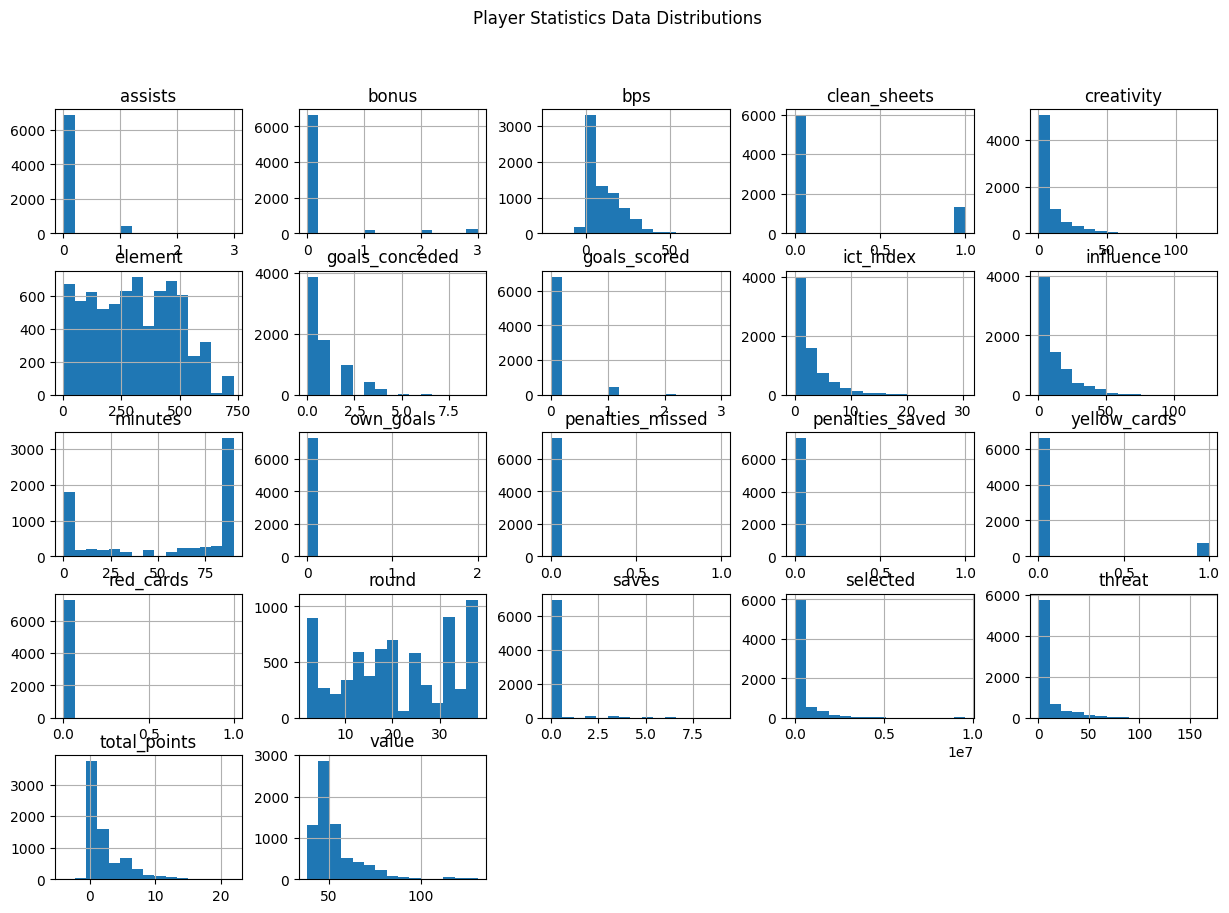

In [21]:
player_df.drop(['match_date','was_home'],axis=1).hist(bins=15, figsize=(15, 10))
plt.suptitle("Player Statistics Data Distributions")
plt.show()

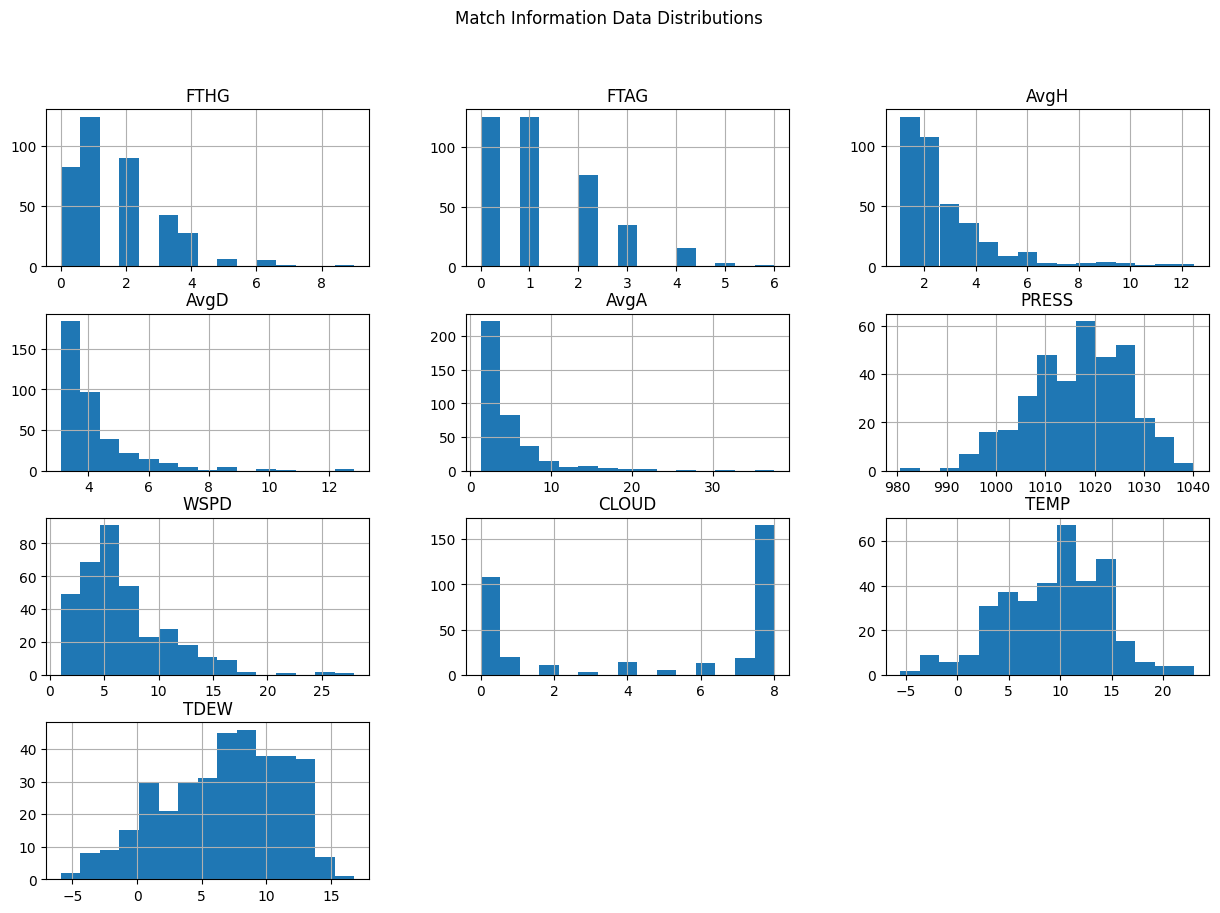

In [20]:
match_df.drop(['Date'],axis=1).hist(bins=15, figsize=(15, 10))
plt.suptitle("Match Information Data Distributions")
plt.show()

Upon initial manual inspection and profiling of the data, no anomalies were observed.

### 1.2. Data Quality Dimensions
#### 1.2.1. Completeness

In ensuring completeness, we carefully verify that every necessary detail is present in both player performance and match information datasets. This includes checking for missing values in key fields such as 'goals_scored' and 'match results', ensuring our data is comprehensive and ready for analysis.

In [24]:
print("Missing Values in Player Performance Dataset:")
print(player_df.isnull().sum())

print("\nMissing Values in Match Information Dataset:")
print(match_df.isnull().sum())

Missing Values in Player Performance Dataset:
match_date          0
team_x              0
opp_team_name       0
was_home            0
name                0
position            0
assists             0
bonus               0
bps                 0
clean_sheets        0
creativity          0
element             0
goals_conceded      0
goals_scored        0
ict_index           0
influence           0
minutes             0
own_goals           0
penalties_missed    0
penalties_saved     0
yellow_cards        0
red_cards           0
round               0
saves               0
selected            0
threat              0
total_points        0
value               0
dtype: int64

Missing Values in Match Information Dataset:
Date         0
HomeTeam     0
AwayTeam     0
FTHG         0
FTAG         0
FTR          0
AvgH         0
AvgD         0
AvgA         0
PRESS       22
WDIR        22
WSPD        22
CLOUD       22
TEMP        22
TDEW        22
dtype: int64


#### 1.2.2. Uniqueness

To maintain uniqueness, we scrutinize our datasets for duplicate entries. In the player performance dataset, we ensure each player's data is recorded only once per match. Similarly, in the match information dataset, we confirm that each match is uniquely represented, preventing data redundancy.

In [25]:
print("\nDuplicate Rows in Player Performance Dataset:")
print(player_df[player_df.duplicated()])

print("\nDuplicate Rows in Match Information Dataset:")
print(match_df[match_df.duplicated()])


Duplicate Rows in Player Performance Dataset:
Empty DataFrame
Columns: [match_date, team_x, opp_team_name, was_home, name, position, assists, bonus, bps, clean_sheets, creativity, element, goals_conceded, goals_scored, ict_index, influence, minutes, own_goals, penalties_missed, penalties_saved, yellow_cards, red_cards, round, saves, selected, threat, total_points, value]
Index: []

Duplicate Rows in Match Information Dataset:
Empty DataFrame
Columns: [Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, AvgH, AvgD, AvgA, PRESS, WDIR, WSPD, CLOUD, TEMP, TDEW]
Index: []


#### 1.2.3. Consistency

We prioritize consistency by standardizing formats and values across our datasets. This involves aligning player positions and team names in the player performance dataset and ensuring date formats and team references in the match information dataset are uniform, facilitating smoother data handling.

In [26]:
print("Unique values in 'position' column in Player Dataset:")
print(player_df['position'].unique())

print("\nUnique values in 'team_x' column in Player Dataset:")
print(player_df['team_x'].unique())

print("\nOut-of-Range Values in 'minutes' column:")
print(player_df[player_df['minutes'] > 90]) 

Unique values in 'position' column in Player Dataset:
['DEF' 'FWD' 'MID' 'GK']

Unique values in 'team_x' column in Player Dataset:
['Newcastle' "Nott'm Forest" 'Crystal Palace' 'Leicester' 'West Ham'
 'Liverpool' 'Southampton' 'Fulham' 'Man City' 'Spurs' 'Wolves' 'Man Utd'
 'Leeds' 'Chelsea' 'Bournemouth' 'Arsenal' 'Brentford' 'Brighton'
 'Aston Villa' 'Everton']

Out-of-Range Values in 'minutes' column:
Empty DataFrame
Columns: [match_date, team_x, opp_team_name, was_home, name, position, assists, bonus, bps, clean_sheets, creativity, element, goals_conceded, goals_scored, ict_index, influence, minutes, own_goals, penalties_missed, penalties_saved, yellow_cards, red_cards, round, saves, selected, threat, total_points, value]
Index: []


#### 1.2.4. Accuracy

We need to confirm the correctness of the recorded data. For player statistics and match results, we ensure that the information accurately reflects the actual events, forming a reliable basis for our subsequent analyses.

In [28]:
# TODO

## 2. Denial Constraints
